Intuitively, one can think neighbouring countries have similar taste for music. How can we show, indeed, this is the case? In this analysis, we will utilize network analysis on the dataset scraped from Spotify.
We will use top 200 chart for every country listed on Spotify. After gathering several features regarding these songs, a bipartite network will be constructed on songs and countries using Networkx library. After that, unipartite projection of network will indicate number of common songs between countries listed on their top 200 charts- weighted with the rank of song. Thus, we will be able identify whether song preference is strong with countries that are geographically close.

Importing files and libraries

In [ ]:
import warnings
warnings.simplefilter('ignore')
!pip install node2vec
!pip install plotly-express
!pip install birankpy

In [ ]:
import pandas as pd
import numpy as np
import birankpy
import matplotlib.pyplot as plt
from random import sample
import random
import networkx as nx
from node2vec import Node2Vec
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from itertools import combinations
from node2vec.edges import HadamardEmbedder
from node2vec.edges import WeightedL1Embedder
from node2vec.edges import WeightedL2Embedder
from node2vec.edges import AverageEmbedder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from networkx.algorithms import community as nxcomm
from networkx.algorithms import bipartite
from sklearn import metrics as met
from scipy.stats import chi2_contingency
from yellowbrick.target import FeatureCorrelation
bn = birankpy.BipartiteNetwork()

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
#for my drive
%cd /gdrive/My Drive/516NetworkAnalysis/

/gdrive/My Drive/516NetworkAnalysis


In [ ]:
df1=pd.read_csv('dataset3.csv')

In [ ]:
df1.head()

Date Country  ... ArtistPopularity ArtistGenre1
0  2017-01-31  global  ...             93.0          pop
1  2017-02-28  global  ...             93.0          pop
2  2017-03-31  global  ...             93.0          pop
3  2017-04-30  global  ...             93.0          pop
4  2017-06-30  global  ...             93.0          pop

[5 rows x 21 columns]

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567913 entries, 0 to 567912
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Date              567913 non-null  object 
 1   Country           567913 non-null  object 
 2   Track Name        567860 non-null  object 
 3   Streams           567913 non-null  object 
 4   Position          567913 non-null  int64  
 5   URL               567913 non-null  object 
 6   ArtistID          567902 non-null  object 
 7   ArtistGenre       562340 non-null  object 
 8   danceability      567902 non-null  float64
 9   energy            567902 non-null  float64
 10  key               567902 non-null  float64
 11  loudness          567902 non-null  float64
 12  mode              567902 non-null  float64
 13  speechiness       567902 non-null  float64
 14  acousticness      567902 non-null  float64
 15  instrumentalness  567902 non-null  float64
 16  liveness          56

# Processing Raw Data

After reading data, I dropped null values if there is any.<br>
Artist name, track name and year of the song are needed to be derived in the dataset. <br>
Some songs have several artists collaborated, I created 3 different artist name features for that. <br>
Other column transformation such as getting stream feature and change of feature type is needed.

In [ ]:
df2=df1.dropna()

In [ ]:
 df2["Track"]=df2["Track Name"].apply(lambda x:x.split(" by ")[0]).str.strip()

In [ ]:
df2["Artists"]=df2["Track Name"].apply(lambda x:x.split(" by ")[1]).str.strip()

In [ ]:
df2["Year"]=df2["Date"].apply(lambda x:x.split("-")[0]).str.strip()

In [ ]:
df2["Artist1"]=df2["Artists"].apply(lambda x:x.split(",")[0]).str.strip()

In [ ]:
df2["Artist2"]=df2["Artists"].apply(lambda x: x.split(",")[1] if len(x.split(","))>1 else False).str.strip()

In [ ]:
df2["Artist3"]=df2["Artists"].apply(lambda x: x.split(",")[2] if len(x.split(","))>2 else False).str.strip()

In [ ]:
df2["Streams"]=df2["Streams"].apply(lambda x:x.replace(",", ""))

In [ ]:
df2["Streams"]=df2['Streams'].astype('float')

In [ ]:
df2["Track"]=df2["Track"].apply(lambda x:x.strip())

In [ ]:
df2.Year = df2.Year.astype('int64')


In [ ]:
df2.tail()

Date Country  ...    Artist2  Artist3
567908  2021-04-30      za  ...     Boohle      NaN
567909  2021-04-30      za  ...      Makwa      NaN
567910  2021-04-30      za  ...        NaN      NaN
567911  2021-04-30      za  ...  Master KG      NaN
567912  2021-04-30      za  ...        NaN      NaN

[5 rows x 27 columns]

# Exploratory Data Analysis

In [ ]:
genrelist=df2.ArtistGenre1.value_counts()[:15].index

In [ ]:
genlist=genrelist.to_list()

In [ ]:
genlist

['dance pop',
 'latin',
 'pop',
 'colombian pop',
 'electropop',
 'k-pop',
 'dfw rap',
 'alt z',
 'emo rap',
 'canadian pop',
 'canadian hip hop',
 'melodic rap',
 'atl hip hop',
 'modern rock',
 'german hip hop']

In [ ]:
df3=df2[df2.ArtistGenre1.isin(genlist)]

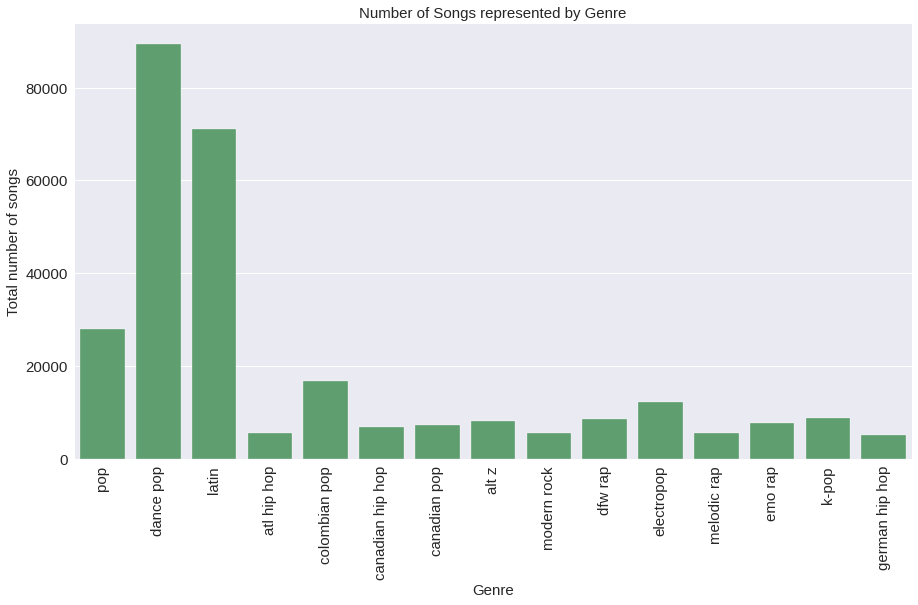

In [ ]:
plt.figure(figsize=(15,8))
a=sns.countplot(df3.ArtistGenre1,color="g")
a.set_xlabel("Genre",fontsize=15)
a.set_ylabel("Total number of songs",fontsize=15)
a.set_title("Number of Songs represented by Genre",fontsize=15)
plt.xticks(rotation=90,fontsize=15)
plt.yticks(fontsize=15)
plt.show()


In [ ]:
df4=df2[["Artist1","ArtistPopularity"]].drop_duplicates().sort_values(by=['ArtistPopularity'],ascending=False)

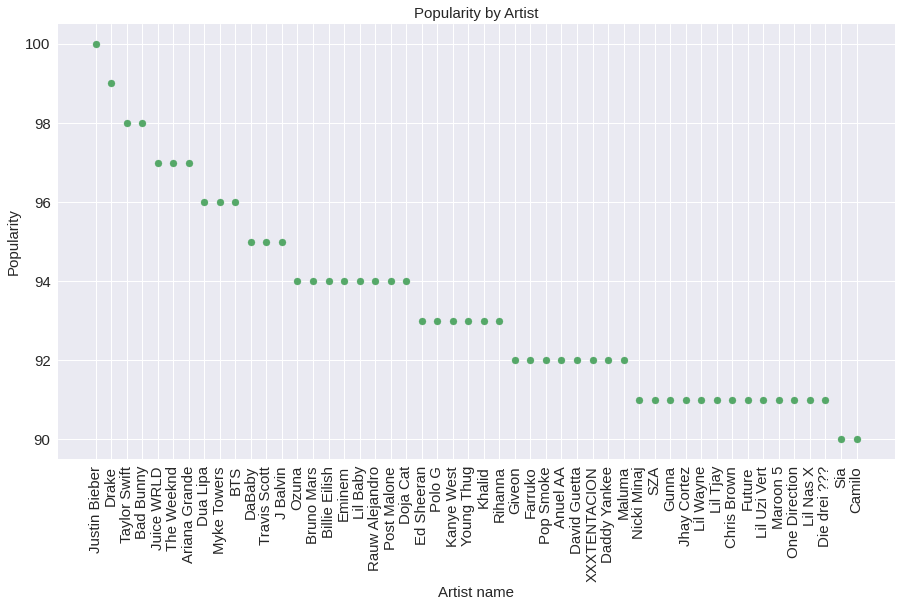

In [ ]:
plt.figure(figsize=(15,8))
bx=plt.axes()
bx.scatter(df4['Artist1'][:50],df4['ArtistPopularity'][:50],color="g")
bx.set_xlabel("Artist name",fontsize=15)
bx.set_ylabel("Popularity",fontsize=15)
bx.set_title("Popularity by Artist",fontsize=15)
plt.xticks(rotation=90,fontsize=15)
plt.yticks(fontsize=15)
plt.show()


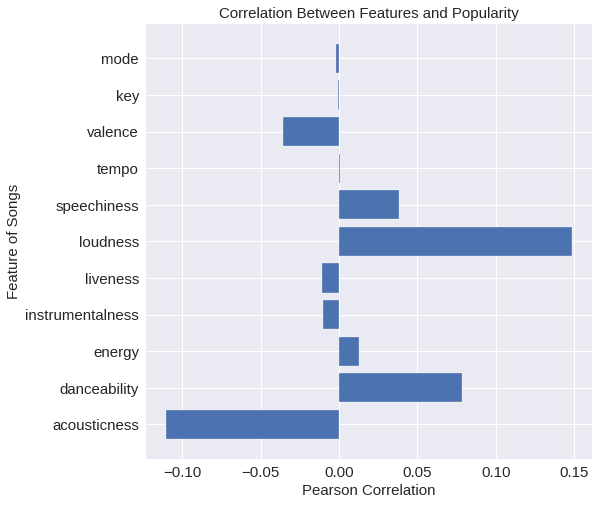

In [ ]:


feature_names = ['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'valence','key','mode']

X, y = df2[feature_names], df2['ArtistPopularity']

# Create a list of the feature names

features = np.array(feature_names)

# Instantiate the visualizer
visualizer = FeatureCorrelation(labels=features)

plt.rcParams['figure.figsize']=(10,8)
visualizer.fit(X, y)        # Fit the data to the visualizer
plt.xlabel('Pearson Correlation',fontsize=15)
plt.ylabel('Feature of Songs',fontsize=15)
plt.title('Correlation Between Features and Popularity',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()    



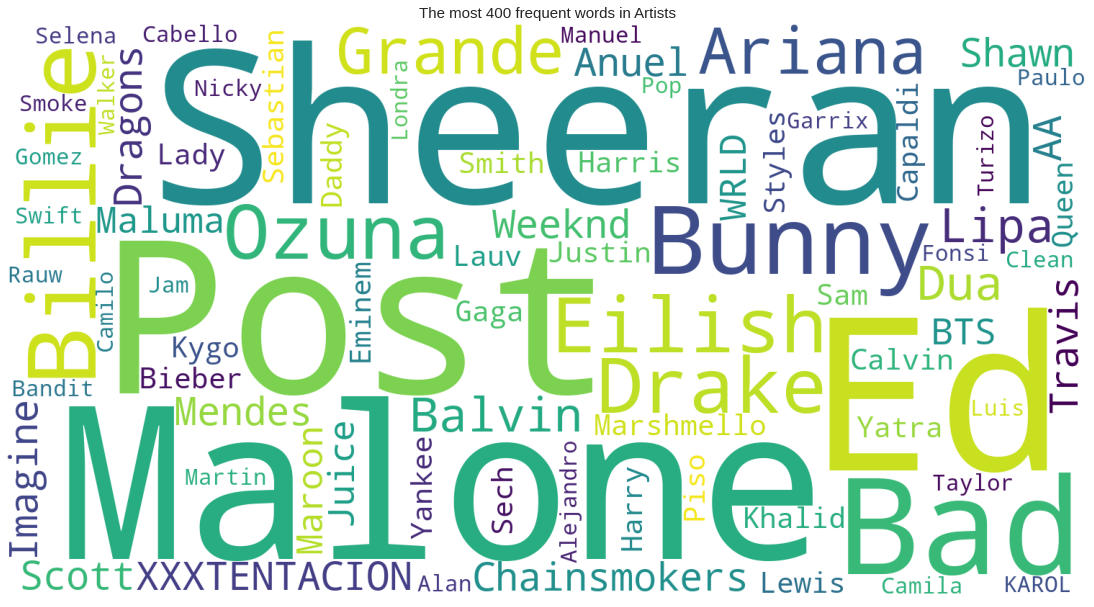

In [ ]:
from wordcloud import WordCloud
plt.style.use('seaborn')
wrds1 = df2["Artists"].str.split(",").str[0].value_counts().keys()[:50]
max_words = 400
wordcloud = WordCloud(width = 1500, height = 800, 
                background_color ='white', max_words = max_words, colormap="viridis",
                min_font_size = 10).generate(" ".join(wrds1))

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud)
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.title(f"The most {max_words} frequent words in Artists",fontsize=15)
plt.show()


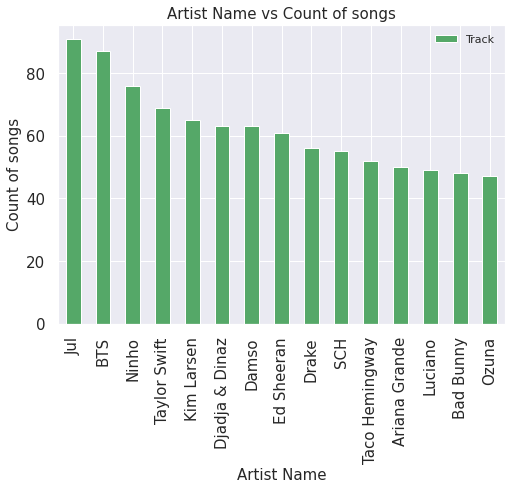

<Figure size 1440x720 with 0 Axes>

In [ ]:

df2[['Artists','Track']].dropna().drop_duplicates().groupby('Artists').count().sort_values(by='Track',ascending = False)[:15].plot(kind = 'bar',color="g")
plt.xlabel('Artist Name', fontsize = 15)
plt.ylabel('Count of songs', fontsize = 15)
plt.title('Artist Name vs Count of songs', fontsize = 15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.figure(figsize=(20, 10))
plt.show()

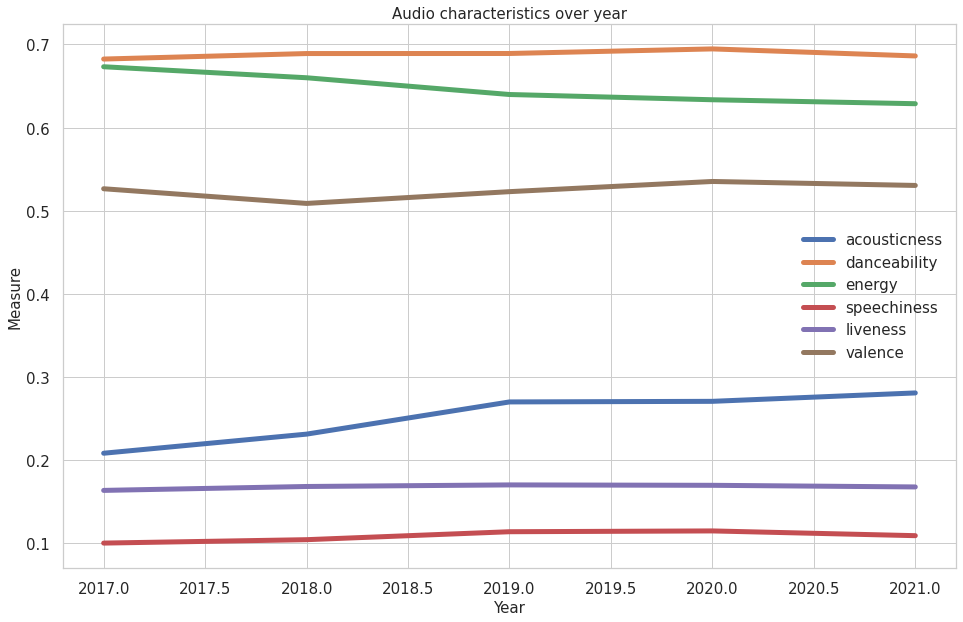

In [ ]:
plt.figure(figsize=(16, 10))
sns.set(style="whitegrid")
columns = ["acousticness","danceability","energy","speechiness","liveness","valence"]
for col in columns:
    x = df2.groupby("Year")[col].mean()
    ax= sns.lineplot(x=x.index,y=x,label=col,linewidth=5)

ax.set_title('Audio characteristics over year',fontsize=15)
ax.set_ylabel('Measure',fontsize=15)
ax.set_xlabel('Year',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)

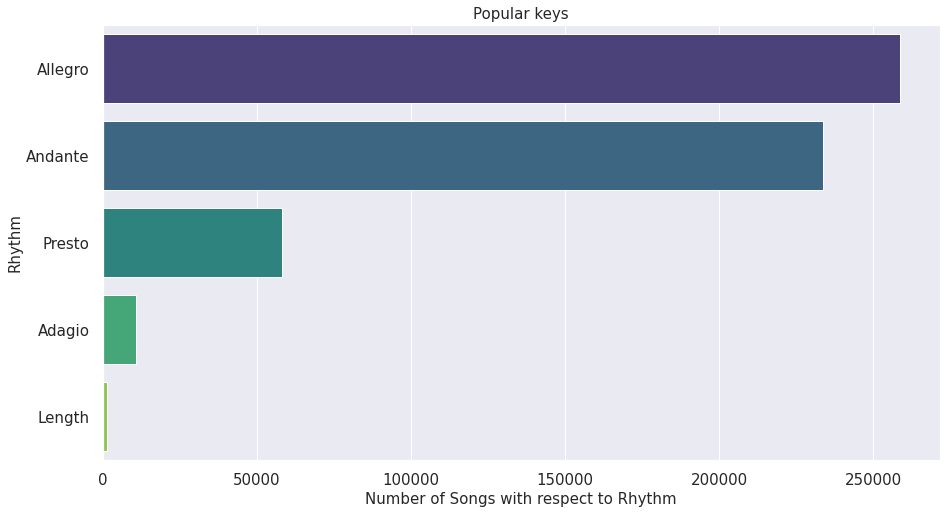

In [ ]:

#The 5 most usual ones were:

#Length: very slow (20 bpm)
#Adagio: slow and majestic (66 to 76 bpm)
#Andante: at the pace, quiet, a little vivacious (76 to 108 bpm)
#Allegro: animated and fast. (110 to 168 bpm).
#Presto: very fast (168 to 200 bpm).

df2['Rhythm']=df2['tempo']

df2.loc[df2['tempo']>168,'Rhythm']='Presto'
df2.loc[(df2['tempo']>110) & (df2['tempo']<=168),'Rhythm']='Allegro'
df2.loc[(df2['tempo']>76) & (df2['tempo']<=110),'Rhythm']='Andante'
df2.loc[(df2['tempo']>=66) & (df2['tempo']<=76),'Rhythm']='Adagio'
df2.loc[df2['tempo']<66,'Rhythm']='Length'
df2['Rhythm'].value_counts()
plt.figure(figsize=(15, 8))
sns.set_style(style='darkgrid')
Rhy=df2['Rhythm'].value_counts()
Rhy_DF=pd.DataFrame(Rhy)
sns.barplot(x=Rhy_DF.Rhythm, y=Rhy_DF.index, palette="viridis")
plt.title('Popular keys',fontsize=15)
plt.xlabel("Number of Songs with respect to Rhythm",fontsize=15)
plt.ylabel("Rhythm",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()



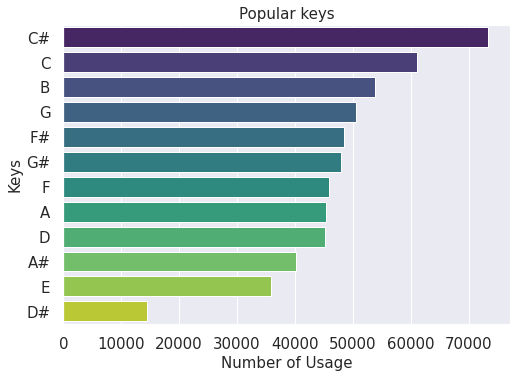

In [ ]:
df2.loc[ df2['key']==0 ,'key']='C'    
df2.loc[ df2['key']==1 ,'key']='C#'    
df2.loc[ df2['key']==2 ,'key']='D'    
df2.loc[ df2['key']==3 ,'key']='D#'    
df2.loc[ df2['key']==4 ,'key']='E'    
df2.loc[ df2['key']==5 ,'key']='F'    
df2.loc[ df2['key']==6 ,'key']='F#'    
df2.loc[ df2['key']==7 ,'key']='G'    
df2.loc[ df2['key']==8 ,'key']='G#'    
df2.loc[ df2['key']==9 ,'key']='A'    
df2.loc[ df2['key']==10 ,'key']='A#' 
df2.loc[ df2['key']==11 ,'key']='B'

sns.set_style(style='darkgrid')
keys=df2['key'].value_counts()
key_DF=pd.DataFrame(keys)
sns.barplot(x=key_DF.key, y=key_DF.index, palette="viridis")
plt.title('Popular keys',fontsize=15)
plt.xlabel("Number of Usage",fontsize=15)
plt.ylabel("Keys",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()


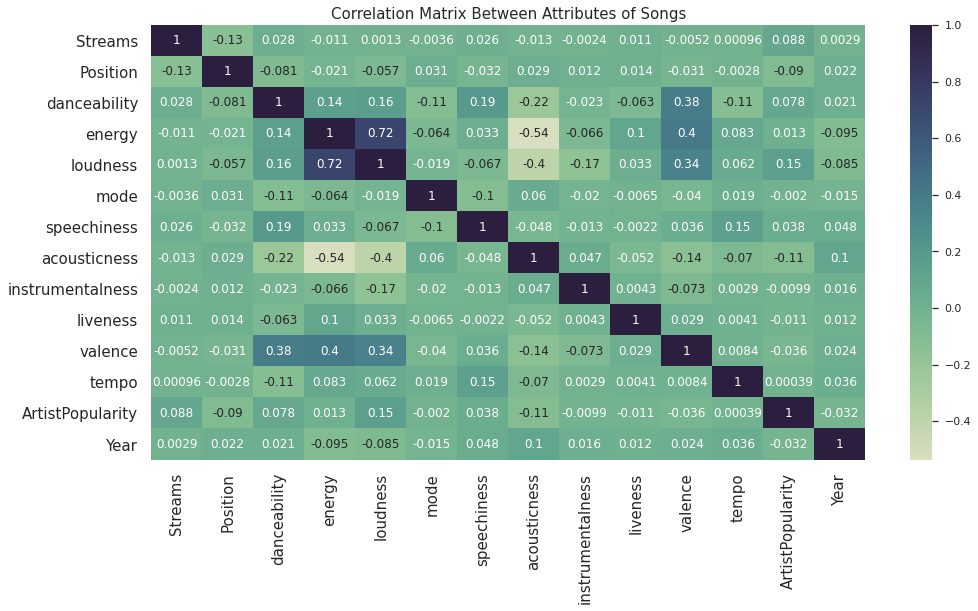

In [ ]:
plt.figure(figsize=(16, 8))

cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)
corr = df2.corr()
sns.heatmap(corr,annot=True,cmap=cmap)
plt.title("Correlation Matrix Between Attributes of Songs",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()


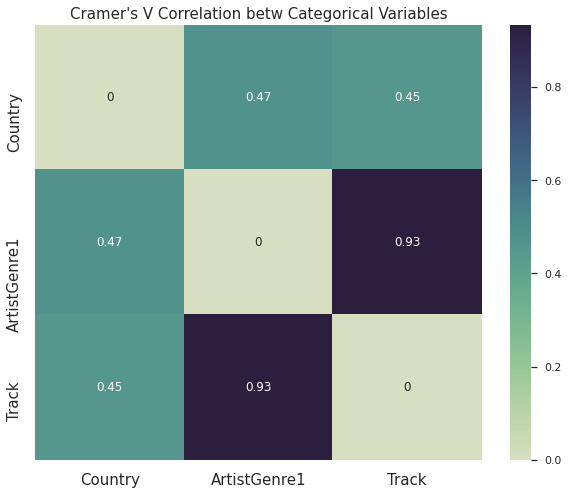

In [ ]:


multi = ['Country','ArtistGenre1', 'Track']

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

import itertools
corrM = np.zeros((len(multi),len(multi)))
for col1, col2 in itertools.combinations(multi, 2):
    idx1, idx2 = df2[multi].columns.get_loc(col1), df2[multi].columns.get_loc(col2)
    corrM[idx1, idx2] = cramers_v(df2[multi][col1], df2[multi][col2])
    corrM[idx2, idx1] = corrM[idx1, idx2]

corr = pd.DataFrame(corrM, index=multi, columns=multi)
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr, annot=True, ax=ax,cmap=cmap); ax.set_title("Cramer\'s V Correlation betw Categorical Variables",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

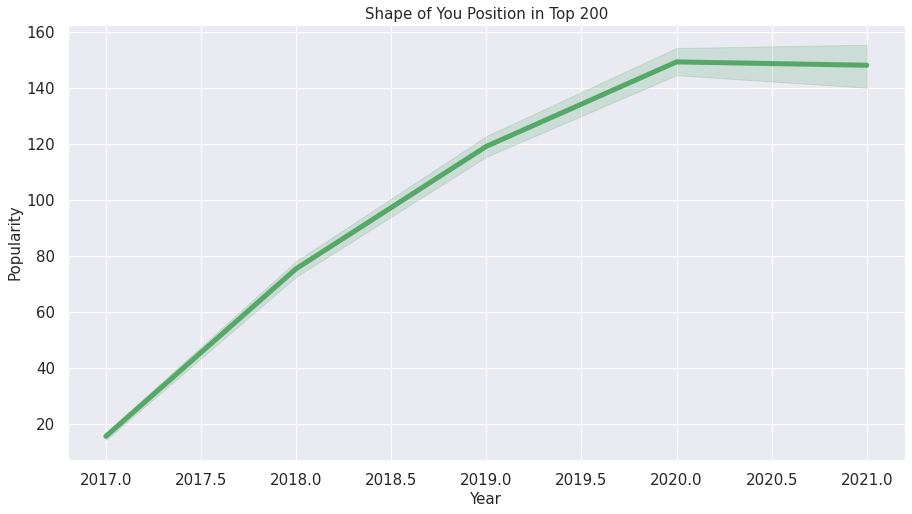

In [ ]:
plt.figure(figsize=(15, 8))
# lets analyze the popularity of Shape of You Posiiton songs over the year
song = df2[df2['Track'] == 'Shape of You']
# grid
sns.set(style='darkgrid')
# line plot passing x,y
sns.lineplot(x='Year', y='Position', data=song, color='g',linewidth=5)
# Labels
plt.title("Shape of You Position in Top 200",fontsize=15)
plt.xlabel('Year',fontsize=15)
plt.ylabel('Popularity',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

# Network Analysis for Countries  / BiPartite Network



We need to create a dataset that includes song name, artist name and the country name.<br>
If the song is listed on the chart of that country, 1 will assigned to the column, 0 otherwise..<br>
Example: Shape of You, USA, 1.<br>
However, the rank of the song in the chart matters too.<br>
In order to weigh, we multiply with 200 and divide by its position. .<br>
So, as position decreases in the chart, weight of the song increases as it is more popular..<br>

In [ ]:
data=pd.DataFrame(columns=['Track','Artists','WeightedOne','Country', 'Year'])

for year in df2["Year"].unique().tolist():
  for country in df2["Country"].unique().tolist():
    firstdf=df2[(df2["Country"]==country) & (df2["Year"]==year)]
    firstdf["One"]=1
    firstdf["WeightedOne"]=(firstdf["One"]*200)/firstdf["Position"]
    seconddf=firstdf[["Track","Artists","WeightedOne"]].groupby(by=["Track","Artists"]).sum().reset_index().sort_values(by=["WeightedOne"],ascending=False)[:50]
    seconddf["Country"]=country
    seconddf["Year"]=year
  
    data=data.append(seconddf)



In [ ]:
data

Track  ...  Year
472                            Shape of You  ...  2017
648                                rockstar  ...  2017
132                       Despacito - Remix  ...  2017
341                                Mi Gente  ...  2017
206                                  Havana  ...  2017
..                                      ...  ...   ...
287                                    Окей  ...  2021
310                                  Рэйман  ...  2021
278                             Нет Проблем  ...  2021
112  Peaches (feat. Daniel Caesar & Giveon)  ...  2021
292                               Пацаны II  ...  2021

[15848 rows x 5 columns]

Creating a subset of dataset with only song name, country and its weight.

In [ ]:
data["Sum"]=np.sum(data.WeightedOne)
data["NormalizedWeight"]=data["WeightedOne"]/data["Sum"]
data["WeightedOne2"]=data["NormalizedWeight"]*100

In [ ]:
datadeneme=data[["Track","Country","WeightedOne2"]]

In [ ]:
datadeneme.head()

Track Country  WeightedOne2
472       Shape of You  global      0.038985
648           rockstar  global      0.036083
132  Despacito - Remix  global      0.025320
341           Mi Gente  global      0.017944
206             Havana  global      0.016237

Networkx requires dataset to be in numbers and names of nodes should be given in dictionaries.<br>
So, last step before constructing network is to prepare appropriate dictionaries and dataset.<br>
Mapping songs and countries into number lists.

In [ ]:
nodenumber=pd.DataFrame(datadeneme["Track"].unique().tolist(),columns=['Track'])

In [ ]:
nodenumber["TrackNumber"]=nodenumber.index+1

In [ ]:
nodenumber

Track  TrackNumber
0           Shape of You            1
1               rockstar            2
2      Despacito - Remix            3
3               Mi Gente            4
4                 Havana            5
...                  ...          ...
4200       Skamming Shit         4201
4201  Infinite Tsukuyomi         4202
4202              Рэйман         4203
4203         Нет Проблем         4204
4204           Пацаны II         4205

[4205 rows x 2 columns]

In [ ]:
nodenumber2=pd.DataFrame(datadeneme["Country"].unique().tolist(),columns=['Country'])

In [ ]:
nodenumber2["CountryNumber"]=range(4248,4316)


In [ ]:
nodenumber2

Country  CountryNumber
0   global           4248
1       us           4249
2       gb           4250
3       ar           4251
4       at           4252
..     ...            ...
63      sa           4311
64      eg           4312
65      ma           4313
66      ru           4314
67      ua           4315

[68 rows x 2 columns]

Creating dataset in terms of mapped numbers

In [ ]:
datadeneme["Track2"]=0
for i in range(len(datadeneme)):
  datadeneme.iloc[i,3]=nodenumber[nodenumber.Track==datadeneme.Track.values[i]]["TrackNumber"].values[0]


In [ ]:
datadeneme["Country2"]=0
for i in range(len(datadeneme)):
  datadeneme.iloc[i,4]=nodenumber2[nodenumber2.Country==datadeneme.Country.values[i]]["CountryNumber"].values[0]


In [ ]:
  dataorig=datadeneme[["Track2","Country2","WeightedOne2"]]

In [ ]:
dataorig

Track2  Country2  WeightedOne2
472       1      4248      0.038985
648       2      4248      0.036083
132       3      4248      0.025320
341       4      4248      0.017944
206       5      4248      0.016237
..      ...       ...           ...
287    2927      4315      0.000745
310    4203      4315      0.000732
278    4204      4315      0.000728
112    3331      4315      0.000695
292    4205      4315      0.000687

[15848 rows x 3 columns]

Now, node types should be given a list, so the algorithm can understand which node is song and which node is country.

In [ ]:
nodetypes=pd.DataFrame(range(1,4316),columns=['node'])

In [ ]:
nodetypes["is_country"]=0

for i in range(len(nodetypes)):
  if nodetypes.node[i]>=4248:
    nodetypes["is_country"][i]=1


In [ ]:
nodetypes

node  is_country
0        1           0
1        2           0
2        3           0
3        4           0
4        5           0
...    ...         ...
4310  4311           1
4311  4312           1
4312  4313           1
4313  4314           1
4314  4315           1

[4315 rows x 2 columns]

Preparing the dictionaries for node names. When network is visualized, names of nodes can be seen.

In [ ]:
d={}
for i in range(len(nodenumber2)):
  d[nodenumber2["CountryNumber"][i]]=nodenumber2["Country"][i]

In [ ]:
d.items()

In [ ]:
d2={}
for i in range(len(nodenumber)):
  d2[nodenumber["TrackNumber"][i]]=nodenumber["Track"][i]

In [ ]:
dataorig=dataorig.rename(columns={ "WeightedOne2": "weight"})

In [ ]:
dataorig

Track2  Country2    weight
472       1      4248  0.038985
648       2      4248  0.036083
132       3      4248  0.025320
341       4      4248  0.017944
206       5      4248  0.016237
..      ...       ...       ...
287    2927      4315  0.000745
310    4203      4315  0.000732
278    4204      4315  0.000728
112    3331      4315  0.000695
292    4205      4315  0.000687

[15848 rows x 3 columns]

So, here comes the big part. Let’s construct our graph by feeding dataset and dictionaries into networkx algorithm.

In [ ]:
G_orig = nx.from_pandas_edgelist(dataorig, source = 'Country2', target = 'Track2',edge_attr=True,  create_using=nx.Graph())
print(nx.info(G_orig))
print("Is bipartite: ", nx.is_bipartite(G_orig))
print("Is connected: ", nx.is_connected(G_orig))
print("Is weighted: ", nx.is_weighted(G_orig))


Name: 
Type: Graph
Number of nodes: 4273
Number of edges: 13742
Average degree:   6.4320
Is bipartite:  True
Is connected:  True
Is weighted:  True


Setting notetype dictionary using nodetypes list.

In [ ]:
nodetype_dict = nodetypes.set_index('node').to_dict('index')
nodetype_dict

In [ ]:
nx.set_node_attributes(G_orig, nodetype_dict)

countries = [x for x,y in G_orig.nodes(data=True) if y['is_country']==1]
tracks = [x for x,y in G_orig.nodes(data=True) if y['is_country']==0]

Visualizing our bipartite network. G_orig graph is fed to visualization layout, labels is set “d” which is our dictionary for country names. In addition, the width of edges is weighted according to links’ weight.

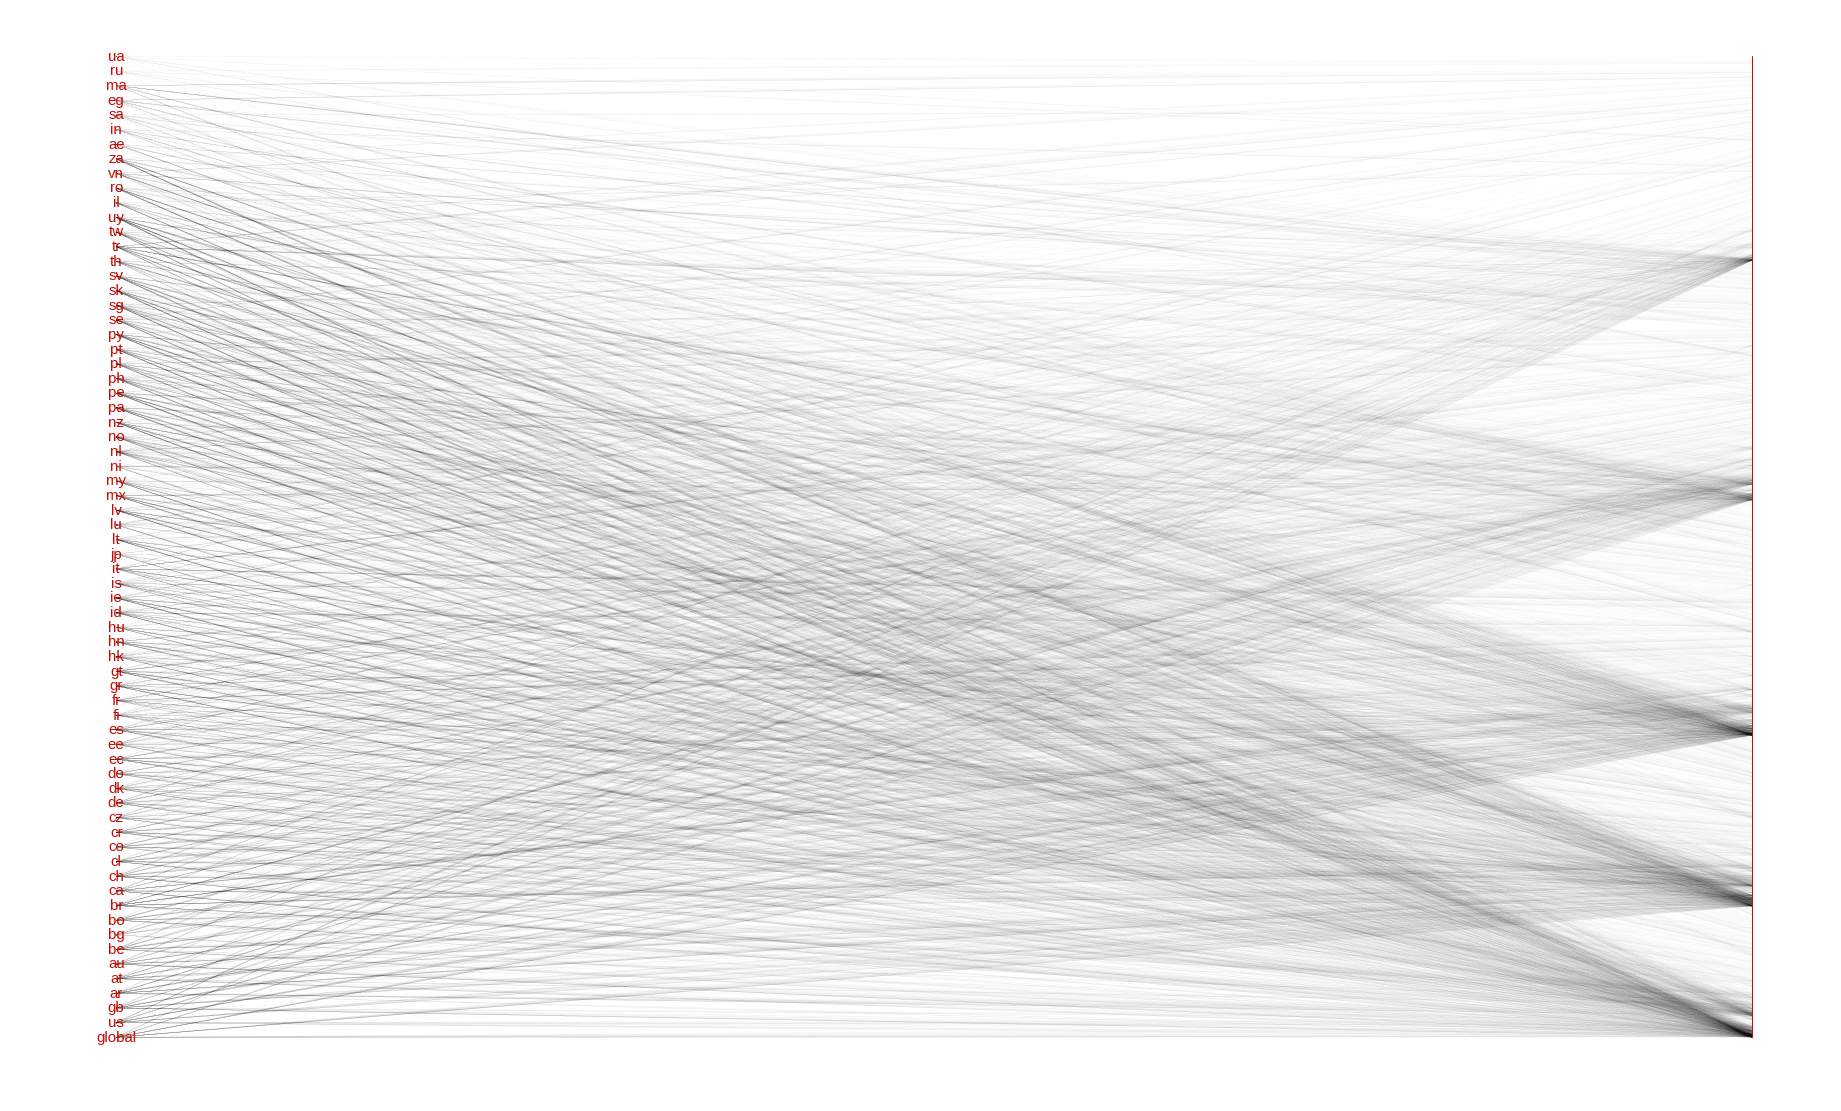

In [ ]:
plt.rcParams['figure.figsize'] = [25, 15]

pos = nx.bipartite_layout(G_orig, countries, align = 'vertical')
nx.draw(G_orig,pos, width = [d["weight"] for (u, v, d) in G_orig.edges(data=True)], node_size = 0.5,labels=d,font_size=15,font_color='r')

There are important network statistics such as centrality scores for nodes, modularity and density of network. Let’s look at them.


In [ ]:
dgc = nx.degree_centrality(G_orig)
cls = nx.closeness_centrality(G_orig)
btw = nx.betweenness_centrality(G_orig,weight='weight')


In [ ]:
cr = pd.DataFrame(index=G_orig.nodes())
cr['dgc'] = cr.index.map(dgc)
cr['cls'] = cr.index.map(cls)
cr['btw'] = cr.index.map(btw)


In [ ]:
cr.sort_values(by='dgc', ascending=False)


dgc       cls       btw
4280  0.055478  0.348024  0.077117
4264  0.055009  0.347911  0.028439
4271  0.054307  0.347741  0.067227
4252  0.054307  0.347741  0.022647
4269  0.054307  0.347741  0.038797
...        ...       ...       ...
1775  0.000234  0.257411  0.000000
1776  0.000234  0.257411  0.000000
1777  0.000234  0.257411  0.000000
1778  0.000234  0.257411  0.000000
4205  0.000234  0.253351  0.000000

[4273 rows x 3 columns]

In [ ]:
cr["name"]=""
for i in cr.index:
  if i>=4248:
    cr["name"][i]=d[i]
  else:
    cr["name"][i]=d2[i]    


In [ ]:
cr2=cr.sort_values(by='dgc', ascending=False)
cr2

dgc       cls       btw            name
4280  0.055478  0.348024  0.077117              it
4264  0.055009  0.347911  0.028439              de
4271  0.054307  0.347741  0.067227              fr
4252  0.054307  0.347741  0.022647              at
4269  0.054307  0.347741  0.038797              es
...        ...       ...       ...             ...
1775  0.000234  0.257411  0.000000     100 Degrees
1776  0.000234  0.257411  0.000000  Celengan Rindu
1777  0.000234  0.257411  0.000000           April
1778  0.000234  0.257411  0.000000          Nyaman
4205  0.000234  0.253351  0.000000       Пацаны II

[4273 rows x 4 columns]

Now, in order to calculate likeliness of countries in terms of music preference, unipartite projection of bipartite graph is needed. Let’s do that. We can do it for either for song, or countries. I will choose projection onto countries. Commong songs in the top 200 list of countries’ are counted. This will be used as an indicator for similarity of music preferences.

In [ ]:
country_net = bipartite.collaboration_weighted_projected_graph(G_orig, countries)
print(nx.info(country_net))
print("Is bipartite: ", nx.is_bipartite(country_net))
print("Is connected: ", nx.is_connected(country_net))
print("Is weighted: ", nx.is_weighted(country_net))

track_net = bipartite.collaboration_weighted_projected_graph(G_orig, tracks)
print(nx.info(track_net))
print("Is bipartite: ", nx.is_bipartite(track_net))
print("Is connected: ", nx.is_connected(track_net))
print("Is weighted: ", nx.is_weighted(track_net))

Name: 
Type: Graph
Number of nodes: 68
Number of edges: 2275
Average degree:  66.9118
Is bipartite:  False
Is connected:  True
Is weighted:  True
Name: 
Type: Graph
Number of nodes: 4205
Number of edges: 691113
Average degree: 328.7101
Is bipartite:  False
Is connected:  True
Is weighted:  True


Getting edges and nodes from unipartite projection.


In [ ]:
a=list(country_net.edges(data=True))

In [ ]:
country1=[]
country2=[]
weight=[]

In [ ]:
for i in range(len(a)):
  country1.append(a[i][0])
  country2.append(a[i][1])
  weight.append(a[i][2]['weight'])

Preparing pandas datasets in terms of edges, nodes and its similarity scores.

In [ ]:
similarcountries=pd.DataFrame({'country1':country1,'country2':country2,'weight':weight})

In [ ]:
similarcountries.country1.values

array([4248, 4248, 4248, ..., 4313, 4313, 4314])

In [ ]:
similarcountries["country1_name"]=""
for i in similarcountries.country1.values:
  idx=similarcountries[similarcountries.country1==i].index
  similarcountries.iloc[idx,3]=d[i]

In [ ]:
similarcountries["country2_name"]=""
for i in similarcountries.country2.values:
  idx=similarcountries[similarcountries.country2==i].index
  similarcountries.iloc[idx,4]=d[i]

In [ ]:
similarcountries.head()

country1  country2    weight country1_name country2_name
0      4248      4249  7.272307        global            us
1      4248      4250  5.621102        global            gb
2      4248      4251  1.385790        global            ar
3      4248      4252  2.872697        global            at
4      4248      4253  7.372115        global            au

Here’s a preview of projected graph. Highest similarity between two countries is Germany and Austria. Second one is Russia and Ukraine. It appeals our intuitions.


In [ ]:
similarcountries.sort_values(by='weight',ascending=False).head(20)

country1  country2     weight country1_name country2_name
273       4252      4264  65.713718            at            de
2274      4314      4315  46.473176            ru            ua
250       4251      4304  39.016074            ar            uy
160       4250      4278  28.925674            gb            ie
268       4252      4259  27.946445            at            ch
686       4259      4264  26.472237            ch            de
75        4249      4258  25.944341            us            ca
935       4263      4299  19.014821            cz            sk
1854      4286      4298  18.457368            my            sg
1545      4277      4286  18.419510            id            my
604       4257      4295  17.718030            br            pt
420       4254      4288  17.487712            be            nl
798       4261      4267  17.056998            co            ec
2127      4298      4303  16.791048            sg            tw
1126      4267      4292  16.471074            ec            pe
518       4256      4267  16.179627            bo            ec
543       4256      4292  15.359303            bo            pe
1482      4275      4300  15.140222            hn            sv
1982      4291      4296  15.092792            pa            py
1440      4274      4298  14.918311            hk            sg

Let’s visualize it.

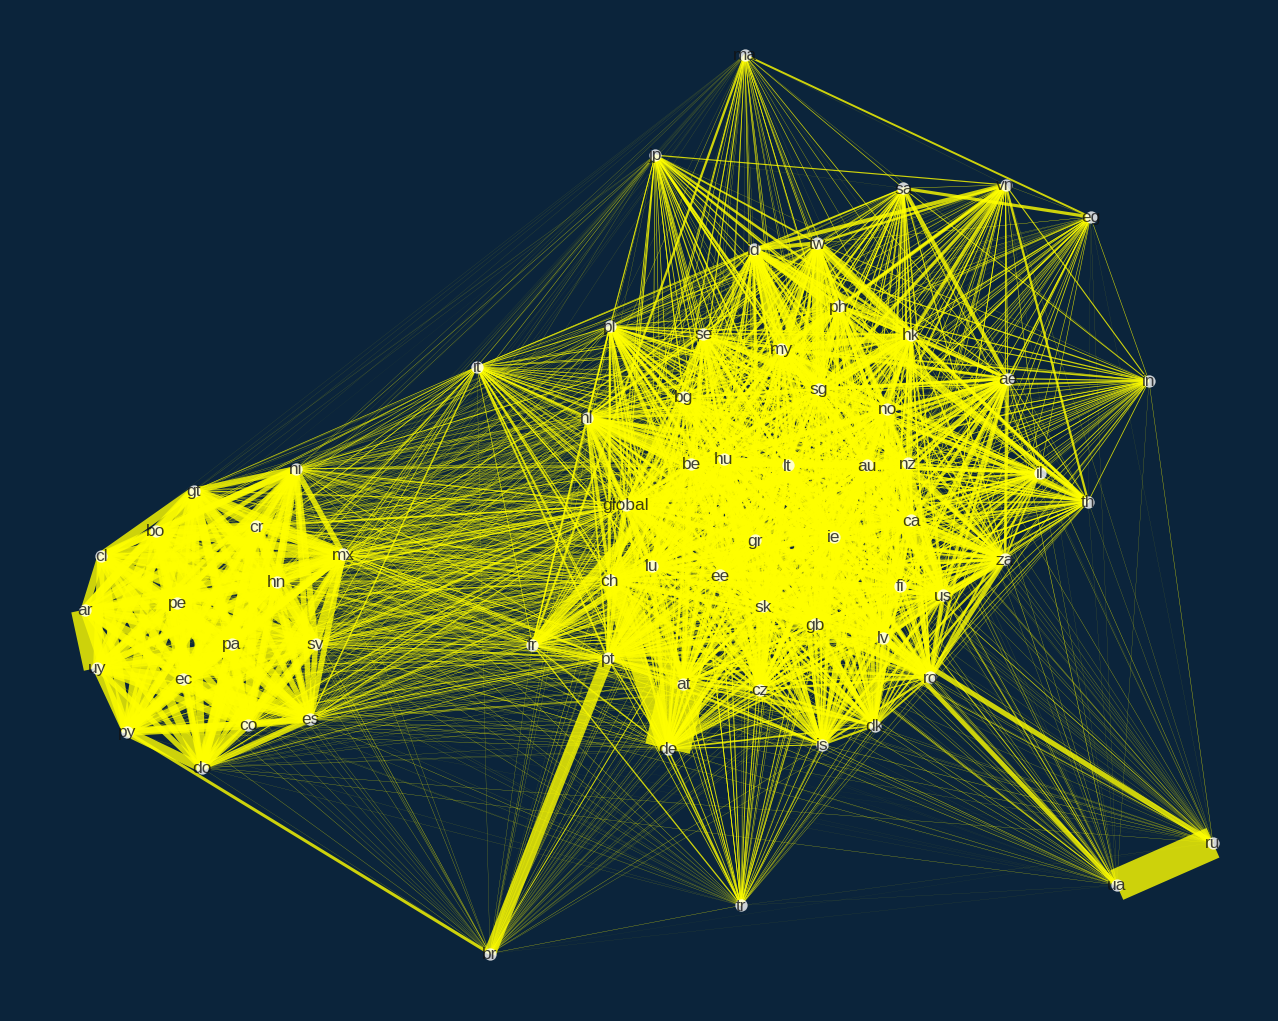

In [ ]:
#Visualization of the component with the most nodes
core_nodes = max(nx.connected_components(country_net), key=len)
core = country_net.subgraph(core_nodes)
nodes = core.nodes()
degree = core.degree()
colors = [degree[n] for n in nodes]


pos = nx.spring_layout(core,weight='weight')

cmap = plt.cm.viridis_r
cmap = plt.cm.Greys

vmin = min(colors)
vmax = max(colors)

fig = plt.figure(figsize = (25,20), dpi=50)

nx.draw(core,alpha = 0.8, pos=pos,nodelist = nodes, node_color = 'w', with_labels= True,font_size = 25, width = [d["weight"] for (u, v, d) in core.edges(data=True)], cmap = cmap, edge_color ='yellow',labels=d)
fig.set_facecolor('#0B243B')
                            
plt.show()


Apparently, there are two communities in music tastes. Left one is consist of South American countries. Second sphere is mainly European countries while some countries in outer periphery such as Brazil, Turkey, Russia. Width of links indicates strength of similarity of music preferences between two countries.